In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from torch import Tensor
import torch.nn.functional as F
device = torch.device('cuda')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from diffusers import DDIMPipeline, DDIMScheduler, DDPMPipeline, DDPMScheduler, StableDiffusionPipeline
from typing import *
from jaxtyping import *

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
model_key = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_key, torch_dtype=torch.float16).to(device)

pipe.enable_attention_slicing(1)
pipe.unet.to(memory_format=torch.channels_last)

vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
def latents_to_img(latents: Float[Tensor, "BS 4 H W"]) -> Float[Tensor, "BS 3 H W"]:
    """Convert latents to images
    Args:
        latents: Latents to convert
    Returns:
        Images
    """

    latents = 1 / (vae.config.scaling_factor) * latents

    with torch.no_grad():
        imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latent(latent):
    latent = latent.detach().half().to(device)
    with torch.no_grad():
        rgb = latents_to_img(latent)
    rgb = rgb.float().cpu()[0].permute(1, 2, 0)
    return rgb

def get_text_embeds(
    prompt: Union[str, List[str]], negative_prompt: Union[str, List[str]]
) -> Float[Tensor, "2 max_length embed_dim"]:
    """Get text embeddings for prompt and negative prompt
    Args:
        prompt: Prompt text
        negative_prompt: Negative prompt text
    Returns:
        Text embeddings
    """

    # Tokenize text and get embeddings
    text_input = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = pipe.tokenizer(
        negative_prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt"
    )

    with torch.no_grad():
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    return text_embeddings

100%|██████████| 25/25 [00:02<00:00, 10.76it/s]


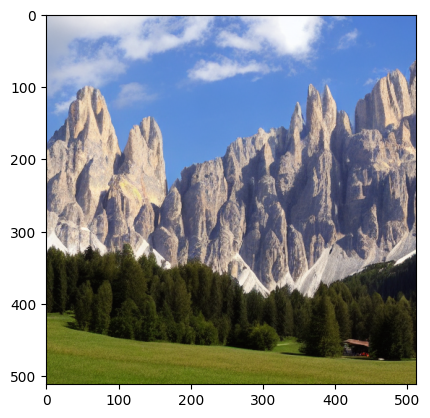

In [4]:
cfg = 7.5
text_embeddings = get_text_embeds("a photo of the dolomites", "")

num_inference_steps = 25
ddpm_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
ddpm_scheduler.num_inference_steps = num_inference_steps
ddpm_scheduler.set_timesteps(num_inference_steps, device=device)

ddpm_scheduler.alphas = ddpm_scheduler.alphas.to(device)
ddpm_scheduler.betas = ddpm_scheduler.betas.to(device)
ddpm_scheduler.alphas_cumprod = ddpm_scheduler.alphas_cumprod.to(device)

timesteps = ddpm_scheduler.timesteps

num_copies = 1

with torch.no_grad():
    num_channels_latents = pipe.unet.config.in_channels

    x_t = pipe.prepare_latents(
        num_copies,
        num_channels_latents,
        512,
        512,
        torch.float,
        device,
        None,
    ).to(device)

    for i, t in enumerate(tqdm(timesteps)):

        t = torch.tensor([t], device=device)

        # Reshape diffusion inputs so that text embeddings match for CFG and multiple copies
        latent_model_input = torch.cat((x_t,) * 2).to(device)
        embed_uncond, embed_cond = text_embeddings.to(device).chunk(2)
        embed_uncond = torch.cat((embed_uncond,) * num_copies)
        embed_cond = torch.cat((embed_cond,) * num_copies)
        text_embedding_input = torch.cat((embed_uncond, embed_cond))
        t_input = torch.cat((t,) * 2 * num_copies)

        noise_pred = pipe.unet(
            latent_model_input.to(torch.float16),
            t_input.to(torch.float16),
            encoder_hidden_states=text_embedding_input.to(torch.float16),
        ).sample

        # perform classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_text + cfg * (noise_pred_text - noise_pred_uncond)
        noise_pred = noise_pred

        x_0_pred = ddpm_scheduler.step(noise_pred, t, x_t).pred_original_sample

        # v_pred for x_t -> x_0_pred_mean
        x_t = ddpm_scheduler.step(noise_pred, t, x_t).prev_sample

        # if i % 5 == 0:
        #     plt.imshow(decode_latent(x_0_pred).numpy())
        #     plt.show()

plt.imshow(decode_latent(x_t).numpy())
plt.show()

## Side by Side

100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


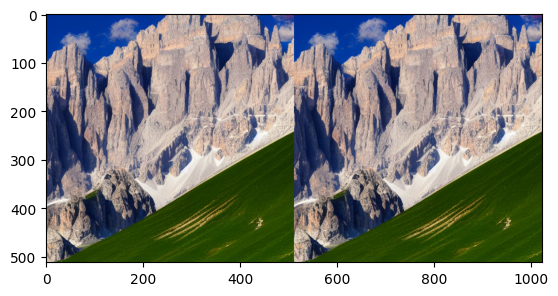

In [5]:
cfg = 7.5
text_embeddings = get_text_embeds("a photo of the dolomites", "")

num_inference_steps = 25
ddpm_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
ddpm_scheduler.num_inference_steps = num_inference_steps
ddpm_scheduler.set_timesteps(num_inference_steps, device=device)

ddpm_scheduler.alphas = ddpm_scheduler.alphas.to(device)
ddpm_scheduler.betas = ddpm_scheduler.betas.to(device)
ddpm_scheduler.alphas_cumprod = ddpm_scheduler.alphas_cumprod.to(device)

timesteps = ddpm_scheduler.timesteps

num_copies = 1

with torch.no_grad():
    num_channels_latents = pipe.unet.config.in_channels

    x_t = pipe.prepare_latents(
        num_copies,
        num_channels_latents,
        512,
        512,
        torch.float,
        device,
        None,
    ).to(device)

    x_0_hat = torch.zeros_like(x_t)
    noise = torch.randn_like(x_0_hat)
    noise = x_t

    # Algo:
    # Get eps hat
    # 

    for i, t in enumerate(tqdm(timesteps)):

        t = torch.tensor([t], device=device)
        t_prev = t - ddpm_scheduler.config.num_train_timesteps // ddpm_scheduler.num_inference_steps

        # Reshape diffusion inputs so that text embeddings match for CFG and multiple copies
        # latent_model_input = torch.cat((x_t,) * 2).to(device)
        embed_uncond, embed_cond = text_embeddings.to(device).chunk(2)
        embed_uncond = torch.cat((embed_uncond,) * num_copies)
        embed_cond = torch.cat((embed_cond,) * num_copies)
        text_embedding_input = torch.cat((embed_cond, embed_uncond))
        t_input = torch.cat((t,) * 2 * num_copies)
        t_prev_input = torch.cat((t_prev,) * 2 * num_copies)

        # reference
        latents_noisy = x_t
        latent_model_input = torch.cat([latents_noisy] * 2, dim=0)
        noise_pred_ref = pipe.unet(
            latent_model_input.to(torch.float16),
            t_input.to(torch.float16),
            encoder_hidden_states=text_embedding_input.to(torch.float16),
        ).sample
        noise_pred_text, noise_pred_uncond = noise_pred_ref.chunk(2)
        noise_pred_ref = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

        # x_t
        if i == 0:
            latents_noisy = ddpm_scheduler.add_noise(x_0_hat, noise, t)
        else:
            # latents_noisy = ddpm_scheduler.add_noise(x_0_hat, noise, t)
            latents_noisy = ddpm_scheduler.add_noise(x_0_hat, noise_pred_prev, t)
        latent_model_input = torch.cat([latents_noisy] * 2, dim=0)
        noise_pred = pipe.unet(
            latent_model_input.to(torch.float16),
            t_input.to(torch.float16),
            encoder_hidden_states=text_embedding_input.to(torch.float16),
        ).sample
        noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

        # print('Prediction difference', F.mse_loss(noise_pred, noise_pred_ref).item())

        alpha_prod_t_prev = ddpm_scheduler.alphas_cumprod[t].to(device)
        w = ((1 - alpha_prod_t_prev) / alpha_prod_t_prev) ** 0.5

        x_0_pred = ddpm_scheduler.step(noise_pred_ref, t, x_t).pred_original_sample

        if i == 0:
            x_0_hat = x_0_pred
            noise = noise_pred
            # print('noise diff:', F.mse_loss(
            #     ddpm_scheduler.add_noise(x_0_hat, noise_pred, t_prev),
            #     ddpm_scheduler.step(noise_pred_ref, t, x_t).prev_sample
            # ).item())
        else:
            x_0_hat += w * (noise_pred_prev - noise_pred)
            # print('noise diff:', F.mse_loss(
            #     ddpm_scheduler.add_noise(x_0_hat, noise_pred, t_prev),
            #     ddpm_scheduler.step(noise_pred_ref, t, x_t).prev_sample
            # ).item())
            noise = noise_pred

        noise_pred_prev = noise_pred

        # print('x_hat difference:', F.mse_loss(x_0_hat, x_0_pred).item())
        x_t = ddpm_scheduler.step(noise_pred_ref, t, x_t).prev_sample

        # print()
        # print()

        # if i % 5 == 0:
        #     sidebyside = torch.cat((decode_latent(x_0_hat), decode_latent(x_0_pred)), dim=1).numpy()
        #     plt.imshow(sidebyside)
        #     plt.show()

sidebyside = torch.cat((decode_latent(x_0_hat), decode_latent(x_0_pred)), dim=1).numpy()
plt.imshow(sidebyside)
plt.show()

## Simplified

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00, 11.12it/s]


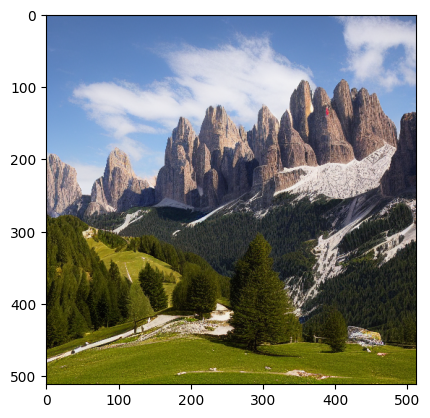

In [7]:
cfg = 7.5
text_embeddings = get_text_embeds("a photo of the dolomites", "")

num_inference_steps = 25
ddpm_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
ddpm_scheduler.num_inference_steps = num_inference_steps
ddpm_scheduler.set_timesteps(num_inference_steps, device=device)

ddpm_scheduler.alphas = ddpm_scheduler.alphas.to(device)
ddpm_scheduler.betas = ddpm_scheduler.betas.to(device)
ddpm_scheduler.alphas_cumprod = ddpm_scheduler.alphas_cumprod.to(device)

timesteps = ddpm_scheduler.timesteps

num_copies = 1

with torch.no_grad():
    num_channels_latents = pipe.unet.config.in_channels

    noise = pipe.prepare_latents(
        num_copies,
        num_channels_latents,
        512,
        512,
        torch.float,
        device,
        None,
    ).to(device)

    noise_pred = noise
    x_0_hat = torch.zeros_like(noise_pred)

    for i, t in enumerate(tqdm(timesteps)):

        t = torch.tensor([t], device=device)
        t_prev = t - ddpm_scheduler.config.num_train_timesteps // ddpm_scheduler.num_inference_steps

        # Reshape diffusion inputs so that text embeddings match for CFG and multiple copies
        embed_uncond, embed_cond = text_embeddings.to(device).chunk(2)
        embed_uncond = torch.cat((embed_uncond,) * num_copies)
        embed_cond = torch.cat((embed_cond,) * num_copies)
        text_embedding_input = torch.cat((embed_cond, embed_uncond))
        t_input = torch.cat((t,) * 2 * num_copies)
        t_prev_input = torch.cat((t_prev,) * 2 * num_copies)

        latents_noisy = ddpm_scheduler.add_noise(x_0_hat, noise_pred, t)
        latent_model_input = torch.cat([latents_noisy] * 2, dim=0)
        noise_pred_prev = pipe.unet(
            latent_model_input.to(torch.float16),
            t_input.to(torch.float16),
            encoder_hidden_states=text_embedding_input.to(torch.float16),
        ).sample
        noise_pred_text, noise_pred_uncond = noise_pred_prev.chunk(2)
        noise_pred_prev = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

        alpha_prod_t_prev = ddpm_scheduler.alphas_cumprod[t].to(device)
        w = ((1 - alpha_prod_t_prev) / alpha_prod_t_prev) ** 0.5

        x_0_hat += w * (noise_pred - noise_pred_prev)

        x_0_ref = ddpm_scheduler.step(noise_pred_prev, t, latents_noisy).pred_original_sample
        # print('x hat diff:', F.mse_loss(
        #     x_0_hat,
        #     x_0_ref
        # ).item())

        noise_pred = noise_pred_prev

sidebyside = decode_latent(x_0_hat).numpy()
plt.imshow(sidebyside)
plt.show()

## Experimentation

In [ ]:
cfg = 7.5
text_embeddings = get_text_embeds("a photo of the dolomites", "")

num_inference_steps = 25
ddpm_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
ddpm_scheduler.num_inference_steps = num_inference_steps
ddpm_scheduler.set_timesteps(num_inference_steps, device=device)

ddpm_scheduler.alphas = ddpm_scheduler.alphas.to(device)
ddpm_scheduler.betas = ddpm_scheduler.betas.to(device)
ddpm_scheduler.alphas_cumprod = ddpm_scheduler.alphas_cumprod.to(device)

timesteps = ddpm_scheduler.timesteps

num_copies = 1

with torch.no_grad():
    num_channels_latents = pipe.unet.config.in_channels

    noise = pipe.prepare_latents(
        num_copies,
        num_channels_latents,
        512,
        512,
        torch.float,
        device,
        None,
    ).to(device)

    noise_pred = noise
    x_0_hat = torch.zeros_like(noise_pred)

    for i, t in enumerate(tqdm(timesteps)):

        t = torch.tensor([t], device=device)
        t_next = t + ddpm_scheduler.config.num_train_timesteps // ddpm_scheduler.num_inference_steps
        t_prev = t - ddpm_scheduler.config.num_train_timesteps // ddpm_scheduler.num_inference_steps

        # Reshape diffusion inputs so that text embeddings match for CFG and multiple copies
        embed_uncond, embed_cond = text_embeddings.to(device).chunk(2)
        embed_uncond = torch.cat((embed_uncond,) * num_copies)
        embed_cond = torch.cat((embed_cond,) * num_copies)
        text_embedding_input = torch.cat((embed_cond, embed_uncond))
        t_input = torch.cat((t,) * 2 * num_copies)
        t_next_input = torch.cat((t_next,) * 2 * num_copies)
        t_prev_input = torch.cat((t_prev,) * 2 * num_copies)


        if i == 0:
            noise_pred_curr = noise_pred
        else:
            latents_noisy = ddpm_scheduler.add_noise(x_0_hat_prev, noise_pred, t_next)
            latent_model_input = torch.cat([latents_noisy] * 2, dim=0)
            noise_pred_curr = pipe.unet(
                latent_model_input.to(torch.float16),
                t_next_input.to(torch.float16),
                encoder_hidden_states=text_embedding_input.to(torch.float16),
            ).sample
            noise_pred_text, noise_pred_uncond = noise_pred_curr.chunk(2)
            noise_pred_curr = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

            tmp = ddpm_scheduler.step(noise_pred_curr, t_next, latents_noisy).pred_original_sample
            print('xt diff', F.mse_loss(latents_noisy, latents_noisy_prev))
            print('x_0 diff here', F.mse_loss(tmp, x_0_ref))
            print('prediction diff', F.mse_loss(noise_pred_curr, noise_pred_prev))

        if i == 0:
            # latents_noisy_prev = noise_pred
            latents_noisy_prev = ddpm_scheduler.add_noise(x_0_hat, noise_pred, t)
            latent_model_input = torch.cat([latents_noisy_prev] * 2, dim=0)
            noise_pred_prev = pipe.unet(
                latent_model_input.to(torch.float16),
                t_input.to(torch.float16),
                encoder_hidden_states=text_embedding_input.to(torch.float16),
            ).sample
            noise_pred_text, noise_pred_uncond = noise_pred_prev.chunk(2)
            noise_pred_prev = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)
        else:
            # latents_noisy_prev = ddpm_scheduler.step(noise_pred_curr, t_next, latents_noisy).prev_sample
            # latents_noisy_prev = x_t
            latents_noisy_prev = ddpm_scheduler.add_noise(x_0_hat, noise_pred_curr, t)
            latent_model_input = torch.cat([latents_noisy_prev] * 2, dim=0)
            noise_pred_prev = pipe.unet(
                latent_model_input.to(torch.float16),
                t_input.to(torch.float16),
                encoder_hidden_states=text_embedding_input.to(torch.float16),
            ).sample
            noise_pred_text, noise_pred_uncond = noise_pred_prev.chunk(2)
            noise_pred_prev = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

        # alpha_prod_t_prev = ddpm_scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = ddpm_scheduler.alphas_cumprod[t].to(device)
        w = ((1 - alpha_prod_t_prev) / alpha_prod_t_prev) ** 0.5

        x_0_ref = ddpm_scheduler.step(noise_pred_prev, t, latents_noisy_prev).pred_original_sample
        x_t = ddpm_scheduler.step(noise_pred_prev, t, latents_noisy_prev).prev_sample

        x_0_hat_prev = x_0_hat
        x_0_hat += w * (noise_pred_curr - noise_pred_prev)
        # x_0_hat += w * (noise_pred_prev - noise_pred_curr)
        
        print('x hat diff:', F.mse_loss(
            x_0_hat,
            x_0_ref
        ).item())

        noise_pred = noise_pred_prev
        # noise_pred = torch.randn_like(noise_pred)

        if i % 9 == 0:
            print("x hat curr")
            decoded = decode_latent(x_0_hat).numpy()
            plt.imshow(decoded)
            plt.show()

            print("x hat pred")
            # decoded = decode_latent(ddpm_scheduler.step(noise_pred_curr, t, latents_noisy).pred_original_sample).numpy()
            decoded = decode_latent(x_0_ref).numpy()
            plt.imshow(decoded)
            plt.show()

        if i == 28:
            break

sidebyside = torch.cat((decode_latent(x_0_hat), decode_latent(x_0_ref)), dim=1).numpy()
plt.imshow(sidebyside)
plt.show()